### Random Forest
Random Forest has feature importance so just a quick test to see what could be most important, vs arthritis

In [ ]:
# Assuming combined_df is your DataFrame
arthritis_columns = [col for col in combined_df.columns if 'arthritis' in col.lower()]

# Display the found columns
combined_df[arthritis_columns]

,Doctor ever said you had arthritis [P_MCQ],Which type of arthritis was it? [P_MCQ]
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,2.0,NaN
4,2.0,NaN
...,...,...
15555,NaN,NaN
15556,NaN,NaN
15557,NaN,NaN
15558,NaN,NaN


In [ ]:
combined_df[arthritis_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15560 entries, 0 to 15559
Data columns (total 2 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Doctor ever said you had arthritis [P_MCQ]  9232 non-null   float64
 1   Which type of arthritis was it? [P_MCQ]     2812 non-null   float64
dtypes: float64(2)
memory usage: 243.3 KB


In [ ]:
combined_df['Doctor ever said you had arthritis [P_MCQ]'].value_counts()

Doctor ever said you had arthritis [P_MCQ]
2.0    6394
1.0    2812
9.0      26
Name: count, dtype: int64

In [ ]:
combined_df['Which type of arthritis was it? [P_MCQ]'].value_counts()

Which type of arthritis was it? [P_MCQ]
1.0    1182
9.0     692
2.0     574
4.0     316
3.0      45
7.0       3
Name: count, dtype: int64

In [ ]:
# It seems the first one is a better test for us
# Lets see how it does with the missing dropped, and also removing the answers of don't know so we can make it binary
rf_df = combined_df.copy()
rf_df.dropna(subset=['Doctor ever said you had arthritis [P_MCQ]'], inplace=True)
rf_df = rf_df[rf_df['Doctor ever said you had arthritis [P_MCQ]'] != 9.0]
rf_df['Doctor ever said you had arthritis [P_MCQ]'].value_counts()

Doctor ever said you had arthritis [P_MCQ]
2.0    6394
1.0    2812
Name: count, dtype: int64

              precision    recall  f1-score   support

         1.0       0.64      0.15      0.24       567
         2.0       0.72      0.96      0.82      1275

    accuracy                           0.71      1842
   macro avg       0.68      0.56      0.53      1842
weighted avg       0.69      0.71      0.64      1842

                                            Feature  Importance
732     Any metal objects inside your body? [P_MCQ]    0.022352
715   Age when 1st had gallbladder surgery? [P_MCQ]    0.007233
725             Doctor told you to exercise [P_MCQ]    0.006932
717          1st cancer - what kind was it? [P_MCQ]    0.005324
699  Ever told you had COPD, emphysema, ChB [P_MCQ]    0.005323
726  Doctor told you to reduce salt in diet [P_MCQ]    0.005018
680    Doctor ever said you were overweight [P_MCQ]    0.004809
714           Ever had gallbladder surgery? [P_MCQ]    0.004707
716  Ever told you had cancer or malignancy [P_MCQ]    0.004691
712          Ever seen a DR about

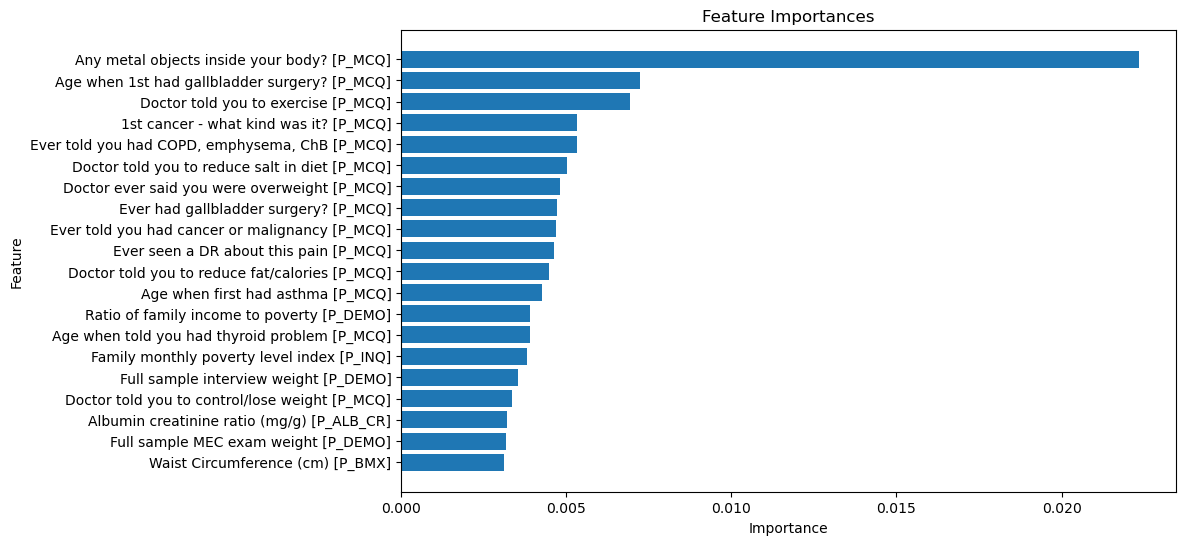

In [ ]:
# Define the feature matrix X and the target vector y
X = rf_df.drop(columns=['Doctor ever said you had arthritis [P_MCQ]'])
y = rf_df['Doctor ever said you had arthritis [P_MCQ]']

# this will make our model lean on this heavily for prediction, so dropping it
X.drop(columns=['Which type of arthritis was it? [P_MCQ]'],inplace=True)

# Convert categorical variables to dummy/indicator variables
X = pd.get_dummies(X, drop_first=True)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

# Get feature importances
feature_importances = rf.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df = importance_df.head(20)

# Display the feature importances
print(importance_df)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.show()

## XGBoost

              precision    recall  f1-score   support

         0.0       0.88      0.93      0.90      2554
         1.0       0.57      0.40      0.47       558

    accuracy                           0.84      3112
   macro avg       0.72      0.67      0.69      3112
weighted avg       0.82      0.84      0.83      3112



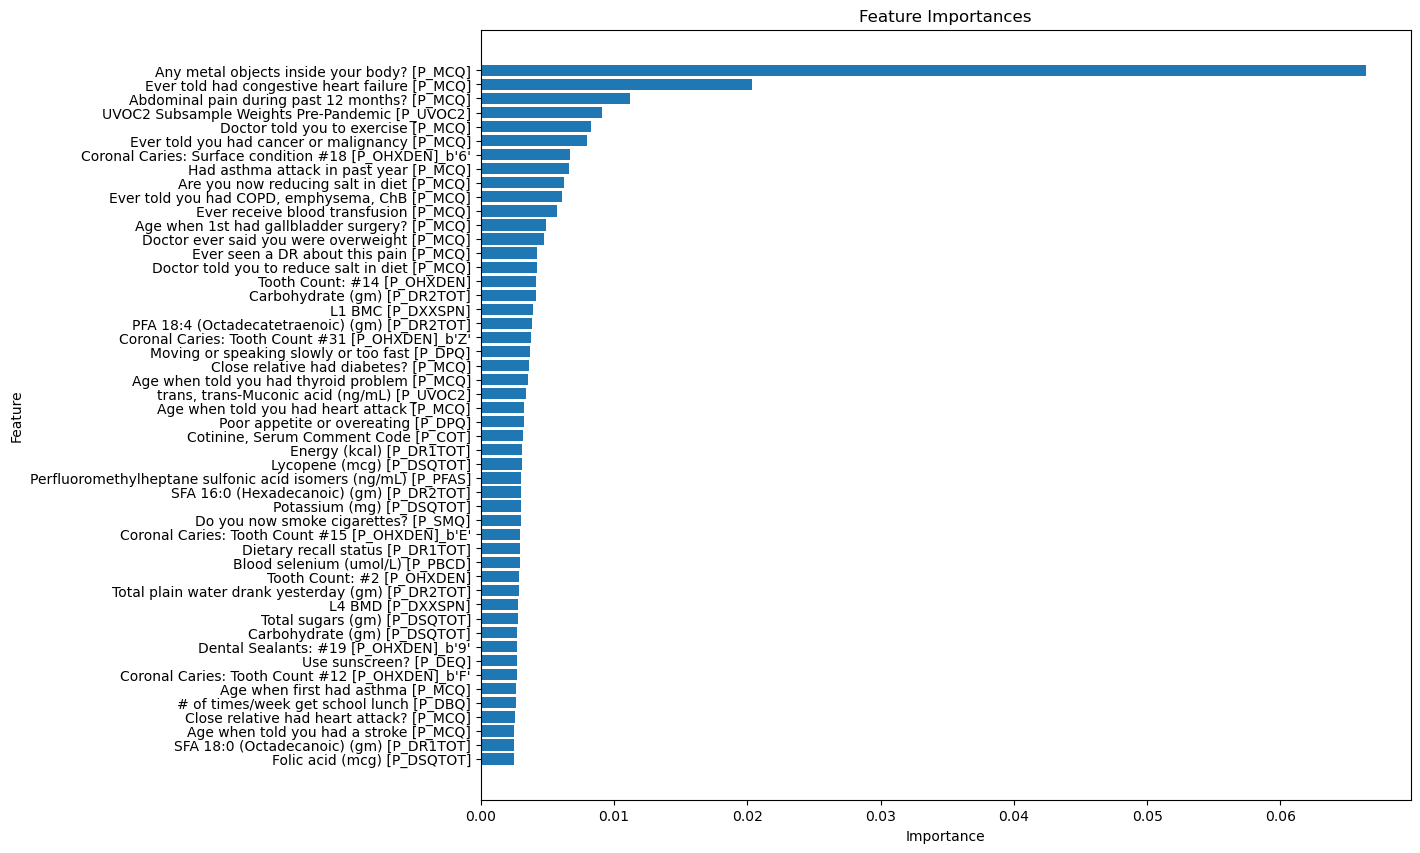

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Copy the combined_df DataFrame
xgboost_df = combined_df.copy()

# Define the feature matrix X and the target vector y
X = xgboost_df.drop(columns=['Doctor ever said you had arthritis [P_MCQ]'])
y = xgboost_df['Doctor ever said you had arthritis [P_MCQ]']

# Map 2, 9, and NaN to 0
y = y.map({1.0: 1, 2.0: 0, 9.0: 0})
y.fillna(0, inplace=True)

# Convert categorical variables to dummy/indicator variables
X = pd.get_dummies(X, drop_first=True)

# Ensure all features are numeric and fill remaining NaNs with 0
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
X.drop(columns=['Which type of arthritis was it? [P_MCQ]'],inplace=True)

# Check for duplicate columns and rename them
def make_unique(column_names):
    seen = set()
    for i, col in enumerate(column_names):
        count = 1
        new_col = col
        while new_col in seen:
            new_col = f"{col}_{count}"
            count += 1
        seen.add(new_col)
        column_names[i] = new_col
    return column_names

X.columns = make_unique(list(X.columns))

# Capture the feature names after all transformations
feature_names = X.columns

# Convert to NumPy arrays
X = X.values
y = y.values

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost Classifier
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Train the model
xgb.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

# Get feature importances
feature_importances = xgb.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df = importance_df[importance_df['Importance'] > 0]

# Display the feature importances
importance_df = importance_df.head(50)

# Plot the feature importances
plt.figure(figsize=(12, 10))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.show()


              precision    recall  f1-score   support

         0.0       0.88      0.93      0.90      2554
         1.0       0.57      0.40      0.47       558

    accuracy                           0.84      3112
   macro avg       0.72      0.67      0.69      3112
weighted avg       0.82      0.84      0.83      3112



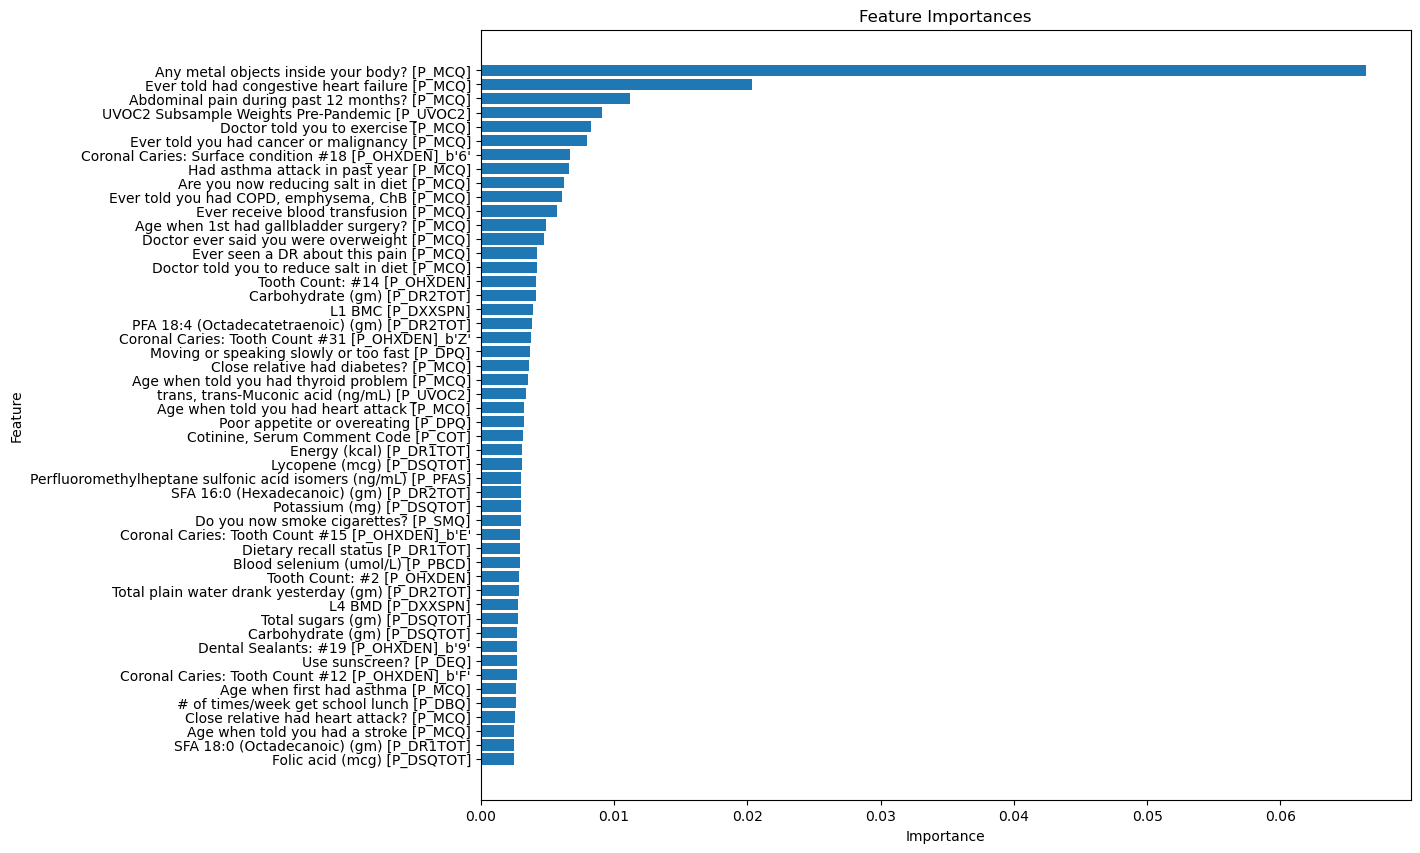

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Copy the combined_df DataFrame
xgboost_df = combined_df.copy()

# Define the feature matrix X and the target vector y
X = xgboost_df.drop(columns=['Doctor ever said you had arthritis [P_MCQ]'])
y = xgboost_df['Doctor ever said you had arthritis [P_MCQ]']

# Map 2, 9, and NaN to 0
y = y.map({1.0: 1, 2.0: 0, 9.0: 0})
y.fillna(0, inplace=True)

# Convert categorical variables to dummy/indicator variables
X = pd.get_dummies(X, drop_first=True)

# Ensure all features are numeric and fill remaining NaNs with 0
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
X.drop(columns=['Which type of arthritis was it? [P_MCQ]'],inplace=True)

# Check for duplicate columns and rename them
def make_unique(column_names):
    seen = set()
    for i, col in enumerate(column_names):
        count = 1
        new_col = col
        while new_col in seen:
            new_col = f"{col}_{count}"
            count += 1
        seen.add(new_col)
        column_names[i] = new_col
    return column_names

X.columns = make_unique(list(X.columns))

# Capture the feature names after all transformations
feature_names = X.columns

# Convert to NumPy arrays
X = X.values
y = y.values

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost Classifier
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Train the model
xgb.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

# Get feature importances
feature_importances = xgb.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df = importance_df[importance_df['Importance'] > 0]

# Display the feature importances
importance_df = importance_df.head(50)

# Plot the feature importances
plt.figure(figsize=(12, 10))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.show()


In [ ]:
# Assuming combined_df is your DataFrame
autoimmune_columns = [col for col in combined_df.columns if 'autoimmune' in col.lower()]

# Display the found columns
combined_df[autoimmune_columns]


,Liver condition: Autoimmune hepatitis [P_MCQ]
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
15555,NaN
15556,NaN
15557,NaN
15558,NaN


In [ ]:
combined_df[autoimmune_columns].value_counts()

Liver condition: Autoimmune hepatitis [P_MCQ]
5.0                                              20
Name: count, dtype: int64

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
15555   NaN
15556   NaN
15557   NaN
15558   NaN
15559   NaN
Name: Liver condition: Autoimmune hepatitis [P_MCQ], Length: 15560, dtype: float64

,SEQN,Interview/Examination status [P_DEMO],Gender [P_DEMO],Age in years at screening [P_DEMO],Race/Hispanic origin w/ NH Asian [P_DEMO],Country of birth [P_DEMO],Length of time in US [P_DEMO],Education level - Adults 20+ [P_DEMO],Marital status [P_DEMO],Full sample interview weight [P_DEMO],...,Pain in left chest [P_CDQ],Pain in left arm [P_CDQ],Pain in epigastric area [P_CDQ],Severe pain in chest more than half hour [P_CDQ],Shortness of breath on stairs/inclines [P_CDQ],SEQN,Ever told you have Hepatitis B? [P_HEQ],Ever prescribed meds treat Hepatitis B? [P_HEQ],Ever told you have Hepatitis C? [P_HEQ],Ever prescribed meds treat Hepatitis C? [P_HEQ]
0,109263.0,2.0,1.0,2.0,6.0,1.0,NaN,NaN,NaN,7891.762435,...,NaN,NaN,NaN,2.0,1.0,109264.0,2.0,NaN,2.0,NaN
1,109264.0,2.0,2.0,13.0,1.0,1.0,NaN,NaN,NaN,11689.747264,...,NaN,NaN,NaN,NaN,2.0,109266.0,2.0,NaN,2.0,NaN
2,109265.0,2.0,1.0,2.0,3.0,1.0,NaN,NaN,NaN,16273.825939,...,NaN,NaN,NaN,2.0,1.0,109267.0,2.0,NaN,2.0,NaN
3,109266.0,2.0,2.0,29.0,6.0,2.0,2.0,5.0,3.0,7825.646112,...,NaN,NaN,NaN,1.0,1.0,109268.0,2.0,NaN,2.0,NaN
4,109267.0,1.0,2.0,21.0,2.0,2.0,3.0,4.0,3.0,26379.991724,...,NaN,NaN,NaN,NaN,2.0,109270.0,2.0,NaN,2.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15555,124818.0,2.0,1.0,40.0,4.0,1.0,NaN,5.0,1.0,21586.596728,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15556,124819.0,2.0,1.0,2.0,4.0,1.0,NaN,NaN,NaN,1664.919253,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15557,124820.0,2.0,2.0,7.0,3.0,1.0,NaN,NaN,NaN,14819.783161,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15558,124821.0,2.0,1.0,63.0,4.0,1.0,NaN,2.0,2.0,4666.817952,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Liver condition: Autoimmune hepatitis [P_MCQ]
5.0    20
Name: count, dtype: int64

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3112

    accuracy                           1.00      3112
   macro avg       1.00      1.00      1.00      3112
weighted avg       1.00      1.00      1.00      3112



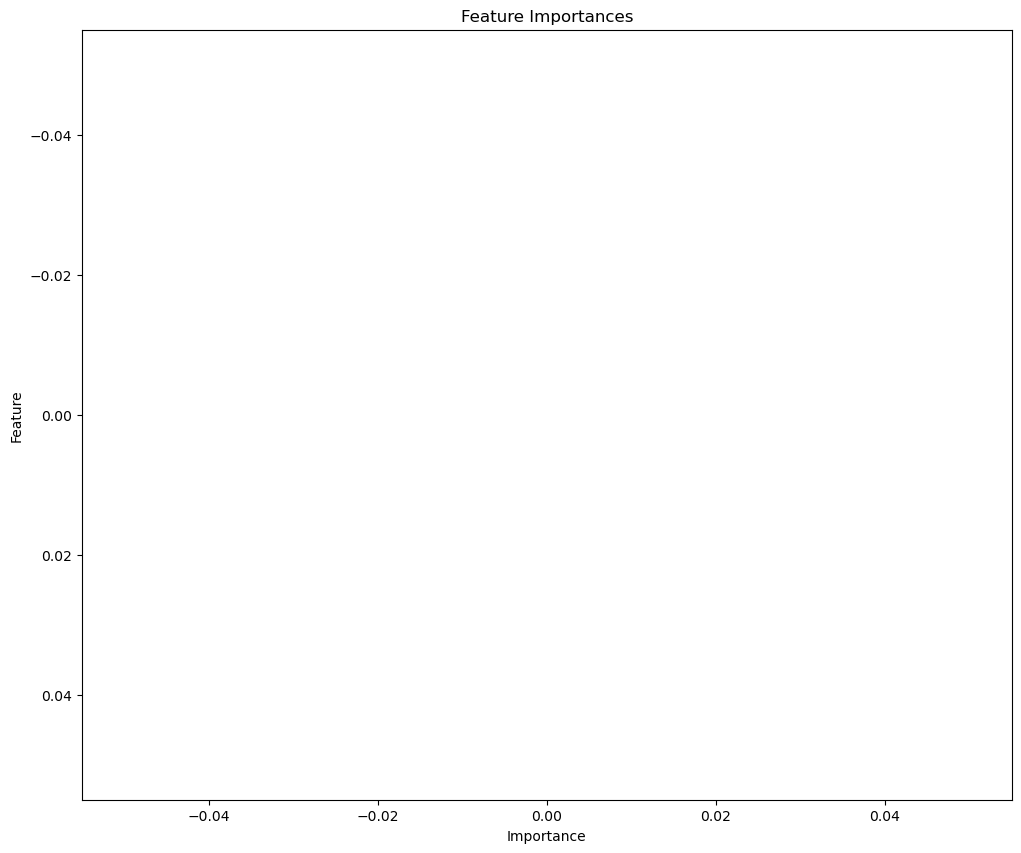

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Copy the combined_df DataFrame
xgboost_df = combined_df.copy()

# Define the feature matrix X and the target vector y
y = xgboost_df[autoimmune_columns[0]]
X = xgboost_df.drop(columns=[autoimmune_columns[0]])
display(y)
display(X)
display(y.value_counts())

# Map 2, 9, and NaN to 0
y = y.map({1.0: 1, 2.0: 0, 9.0: 0})
y.fillna(0, inplace=True)

# Convert categorical variables to dummy/indicator variables
X = pd.get_dummies(X, drop_first=True)

# Ensure all features are numeric and fill remaining NaNs with 0
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
X.drop(columns=['Which type of arthritis was it? [P_MCQ]'],inplace=True)

# Check for duplicate columns and rename them
def make_unique(column_names):
    seen = set()
    for i, col in enumerate(column_names):
        count = 1
        new_col = col
        while new_col in seen:
            new_col = f"{col}_{count}"
            count += 1
        seen.add(new_col)
        column_names[i] = new_col
    return column_names

X.columns = make_unique(list(X.columns))

# Capture the feature names after all transformations
feature_names = X.columns

# Convert to NumPy arrays
X = X.values
y = y.values

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost Classifier
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Train the model
xgb.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

# Get feature importances
feature_importances = xgb.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df = importance_df[importance_df['Importance'] > 0]

# Display the feature importances
importance_df = importance_df.head(50)

# Plot the feature importances
plt.figure(figsize=(12, 10))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.show()


In [ ]:
def clean_dataframe(df):
    # Display the data types count in the original dataframe
    print("Data types before cleaning:")
    print(df.dtypes.value_counts())

    # Function to decode byte strings
    def decode_if_byte_string(value):
        if isinstance(value, bytes):
            return value.decode('utf-8')
        return value

    # Apply the function to the entire dataframe
    df = df.applymap(decode_if_byte_string)

    # Replace specified values with None
    df.replace({"": None, "None": None, "NaN": None, ".": None}, inplace=True)

    # Dictionary to store LabelEncoders
    label_encoders = {}

    # Create a mask for NaN values
    mask = df.isnull()

    # Convert object columns to int64 using LabelEncoder
    for col in df.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        non_null_values = df[col].dropna()
        le.fit(non_null_values)
        transformed_col = df[col].apply(lambda s: -1 if pd.isna(s) else le.transform([s])[0])
        df[col] = transformed_col.astype('int64')
        label_encoders[col] = le  # Store the LabelEncoder in the dictionary

    # Convert float columns with integer-like values to int64 with missing as -1
    for col in df.select_dtypes(include=['float']).columns:
        # Check if all non-NaN values can be converted to integers
        if df[col].dropna().apply(float.is_integer).all():
            df[col] = df[col].fillna(-1).astype('int64')

    # Display the data types count in the cleaned dataframe
    print("Data types after cleaning:")
    print(df.dtypes.value_counts())

    # Report on some of the encodings done, limited to the first 20 columns
    for col, le in list(label_encoders.items())[:20]:
        print(f"Column: {col}")
        encoding_dict = {original_value: le.transform([original_value])[0] for original_value in le.classes_}
        # Add NaN to -1 mapping if any NaN values are present in the column
        if mask[col].any():
            encoding_dict['NaN'] = -1
        print(encoding_dict)
        print(df[col].value_counts())

    return df, label_encoders

cleaned_df = combined_df.copy()
cleaned_df, label_encoders = clean_dataframe(cleaned_df)

## Feature Selection Intuition via Catboost
We have so many columns still, but one trick we can do is load it into catboost because it does a lot of preprocessing and missing handling for you.

This could give us more intuition on which features to select for a final model.

In [ ]:
run_catboost = False

In [ ]:
if run_catboost:
    # Define the feature matrix X and the target vector y
    X = combined_df.drop(columns=['Doctor ever said you had arthritis [P_MCQ]'])
    y = combined_df['Doctor ever said you had arthritis [P_MCQ]']
    X.drop(columns=['Which type of arthritis was it? [P_MCQ]'],inplace=True)

    # Map 2, 9, and NaN to 0
    y = y.map({1.0: 1, 2.0: 0, 9.0: 0})
    y.fillna(0, inplace=True)

    # Convert categorical variables to string and handle NaNs
    categorical_features = X.select_dtypes(include=['object']).columns.tolist()
    X[categorical_features] = X[categorical_features].astype(str).fillna('NaN')

    # Convert numeric columns to float (this will also handle any remaining NaNs in numeric columns)
    numeric_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
    X[numeric_features] = X[numeric_features].fillna(0)

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize the CatBoost Classifier
    catboost_model = CatBoostClassifier(random_state=42, eval_metric='Logloss', cat_features=categorical_features, verbose=0)

    # Train the model
    catboost_model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = catboost_model.predict(X_test)

    # Print the classification report
    print(classification_report(y_test, y_pred))

    # Get feature importances
    feature_importances = catboost_model.get_feature_importance()

    # Create a DataFrame for better visualization
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importances
    })

    # Sort the DataFrame by importance
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    print(importance_df)
    filtered_importance_df = importance_df[importance_df['Importance'] > 0.3]
    filtered_importance_df = importance_df.head(65)

    # Plot the feature importances
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 20))
    plt.barh(filtered_importance_df['Feature'], filtered_importance_df['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importances')
    plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
    plt.show()

Interesting, I am seeing a lot of age related features high up in the list.  

Using sunscreen is an interesting one!

This is just for intuition though.  The results will likely look much different after we properly do EDA and cleaning.